In [1]:
import torch
import numpy as np
import matplotlib.pylab as plt
from IPython.display import clear_output
import torch.nn as nn 
import torch.optim as optim

import transfer
import pipeline
import consts
from importlib import reload
import plot
import json
reload(plot)
reload(transfer)
reload(pipeline)
reload(consts)
plot.prepare_for_plots()

Using cuda device
Using cuda device


<Figure size 864x720 with 0 Axes>

In [2]:
train_dataloader, test_dataloader = pipeline.get_data()

# TransferLearning 5 classes to 10 classes

In [3]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
mask = torch.ones(10).to(consts.device)
for i in range(consts.num_repeats):
    clear_output()
    print(f"Model {i+1}\n-------------------------------"
                      "\n-------------------------------")

    torch.manual_seed(i)

    teacher = pipeline.make_teacher_model()
    teacher.load_state_dict(torch.load(pipeline.get_path()+f'/teacher_5cl_{i}.pt'))
    model = transfer.transfer_last_layer(teacher)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=consts.student_5_learning_rate)
    
    for epoch in range(consts.student_5_training_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        if epoch < 3:
            transfer.freeze_layers(
                model, 
                [True for _ in model.stack[:-1]]+[False] # замораживаем все слои кроме последнего
            )
        else:
            transfer.freeze_layers(
                model, 
                [False for _ in model.stack] # обучаем все слои
            )

        pipeline.train_loop(model,  history, mask, train_dataloader, loss_fn, optimizer)
        pipeline.test_loop(model, history, mask, test_dataloader, loss_fn)
    pipeline.test_loop_fsgm(model, history, mask, test_dataloader, loss_fn, consts.fsgm_eps)
    pipeline.test_loop_noise(model, history, mask, test_dataloader, consts.noise_eps)
    torch.save(model.state_dict(), pipeline.get_path()+f'/transfer_5_{i}.pt')

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Model 10
-------------------------------
-------------------------------
Epoch 1
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 50.2%, Validation loss: 1.461425 

Epoch 2
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 54.2%, Validation loss: 1.352369 

Epoch 3
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 55.3%, Validation loss: 1.306985 

Epoch 4
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 81.7%, Validation loss: 0.719457 

Epoch 5
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 83.5%, Validation loss: 0.648398 

Epoch 6
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 83.9%, Validation loss: 0.617577 

Epoch 7
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 83.2%, Validation loss: 0.600676 

Epoch 8
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 83.9%, Validation loss: 0.587419 

Epoch 9
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 84.4%, Validation loss: 0.580285 

Epoch 10
-------------------------------


Batch #:   0%|          | 0/40 [00:00<?, ?it/s]           

Validation accuracy: 84.7%, Validation loss: 0.574104 



Batch #:   0%|          | 0/40 [00:00<?, ?it/s]         

FSGM Accuracy [0.8473, 0.8233, 0.7946, 0.7616, 0.7266, 0.6915, 0.6541, 0.6146, 0.5809, 0.5427]


Noise Accuracy [0.8473, 0.8431, 0.8329, 0.8151, 0.7921, 0.7387, 0.7087, 0.6734, 0.6318, 0.5916]


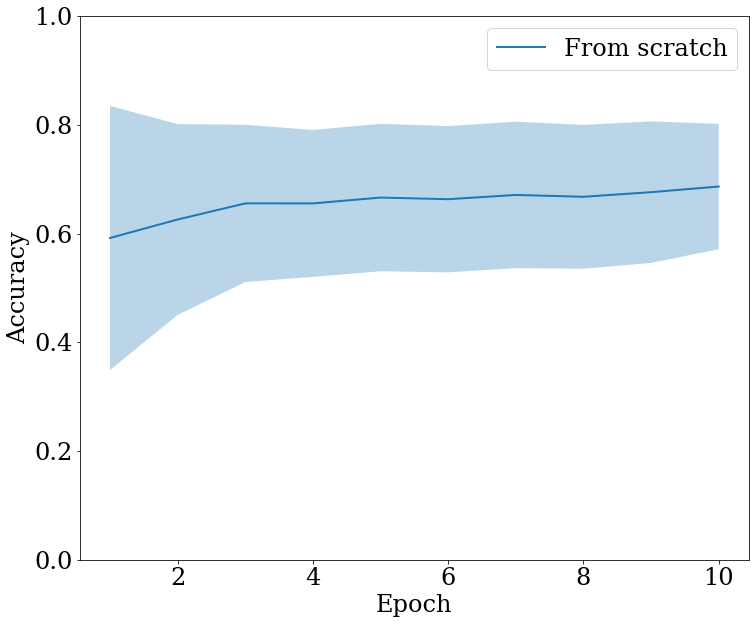

In [4]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], np.arange(1, consts.student_5_training_epochs + 1),
                   ['From scratch'], 'val_acc', 
                    'Epoch', 'Accuracy')

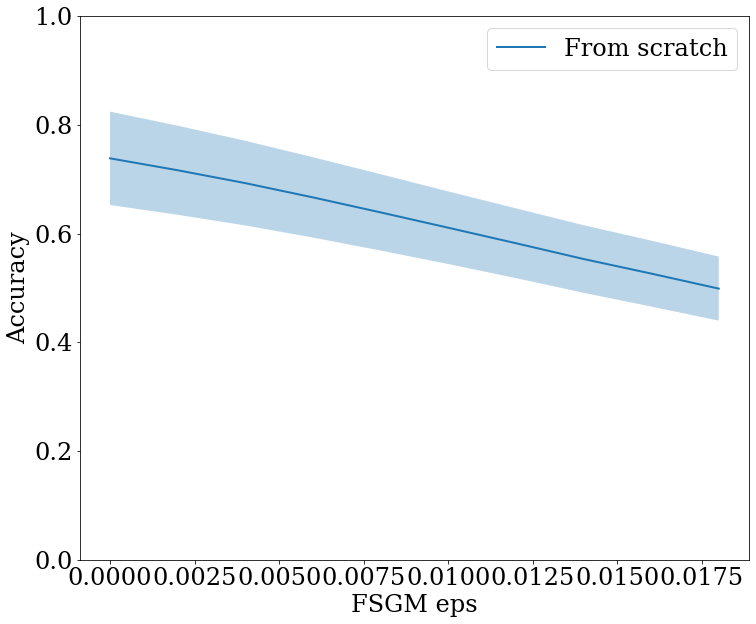

In [5]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], consts.fsgm_eps,
                   ['From scratch'], 'fsgm_noise_acc', 
                    'FSGM eps', 'Accuracy')

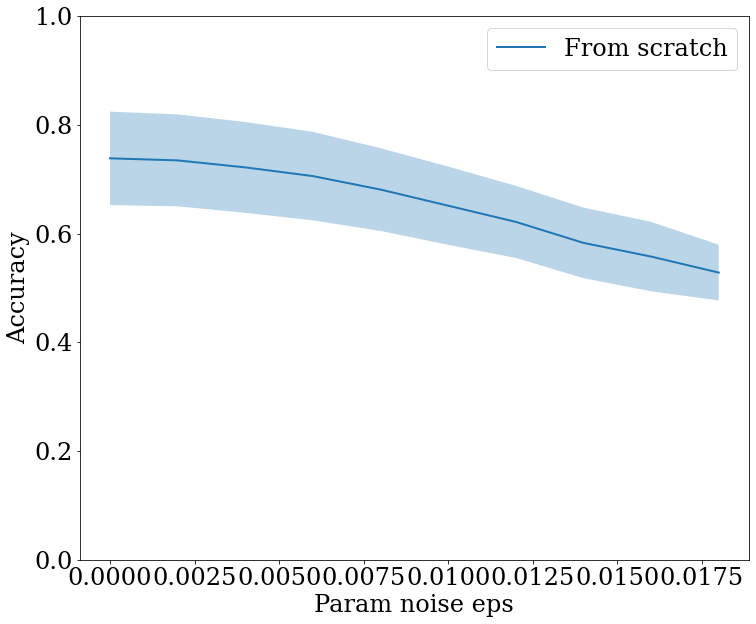

In [6]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], consts.fsgm_eps,
                   ['From scratch'], 'param_noise_acc', 
                    'Param noise eps', 'Accuracy')

In [7]:
with open(pipeline.get_path()+'/history_transfer.json', 'w') as out:
    out.write(json.dumps(history))